In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from llama_cpp import Llama

In [2]:
# === Initialize Model ===
model_name = "llama3.2:1b"
model_path = "/home/prompt5398/.ollama/models/blobs/sha256-74701a8c35f6c8d9a4b91f3f3497643001d63e0c7a84e085bed452548fa88d45"

llm = Llama(
    model_path=model_path,
    n_threads=4,
    n_ctx=2048,
    embedding=True,
    verbose=False
)

llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [3]:
# === Load SQL Examples ===
sql_examples = []
with open('dev.sql', 'r') as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()

    if line.startswith("Question"):
        if "|||" in line:
            nl_part = line.split("|||")[0].split(":", 1)[1].strip()
        else:
            i += 1
            continue

        i += 1
        if i < len(lines) and lines[i].strip().lower().startswith("sql:"):
            sql_part = lines[i].split(":", 1)[1].strip()
            sql_examples.append({
                "natural_language": nl_part,
                "sql_query": sql_part
            })
    i += 1

print(f"Loaded {len(sql_examples)} SQL examples.")
print(f"Sample: {sql_examples[0]}")

FileNotFoundError: [Errno 2] No such file or directory: 'dev.sql'

In [ ]:
# === Construct Full Prompt Pairs ===
full_prompts = [f"{ex['natural_language']}\n{ex['sql_query']}" for ex in sql_examples]
print(full_prompts[:5])

['How many singers do we have ?\nselect count(*) from singer', 'What is the total number of singers ?\nselect count(*) from singer', 'Show name , country , age for all singers ordered by age from the oldest to the youngest .\nselect name ,  country ,  age from singer order by age desc', 'What are the names , countries , and ages for every singer in descending order of age ?\nselect name ,  country ,  age from singer order by age desc', "What is the average , minimum , and maximum age of all singers from France ?\nselect avg(age) ,  min(age) ,  max(age) from singer where country  =  'france'"]


In [ ]:
# === Embedding Extraction Function ===
def get_embeddings(llm, texts, description="", verbose=False):
    print(f"\n🔍 Extracting embeddings for: {description}")
    embeddings = []

    for i, text in enumerate(tqdm(texts, desc=description)):
        try:
            response = llm.embed(text)[-1]

            if verbose and i == 0:
                print("\n📏 Embedding diagnostics:")
                print(f"- Type: {type(response)}")
                print(f"- Length: {len(response)}")
                print(f"- First 5: {response[:5]}")
                print(f"- Last 5: {response[-5:]}")
                print(f"- Min: {min(response)}, Max: {max(response)}")
                print(f"- Mean: {np.mean(response):.4f}, Std: {np.std(response):.4f}")

            embeddings.append(np.array(response))

        except Exception as e:
            print(f"❌ Error at index {i}: {e}\nText: {text[:100]}...")

    embeddings_matrix = np.vstack(embeddings)
    print(f"📐 Matrix shape: {embeddings_matrix.shape}")
    return embeddings, embeddings_matrix

In [ ]:
# === Get Full Embeddings ===
full_embeddings, full_matrix = get_embeddings(llm, full_prompts, "Full Prompt Pairs", verbose=True)


🔍 Extracting embeddings for: Full Prompt Pairs


Full Prompt Pairs:   0%|                       | 1/1034 [00:00<01:53,  9.13it/s]


📏 Embedding diagnostics:
- Type: <class 'list'>
- Length: 2048
- First 5: [1.240502119064331, 0.3397318720817566, 0.790868878364563, 2.990856885910034, -2.7523257732391357]
- Last 5: [0.7519575953483582, -2.6983137130737305, 0.49845173954963684, -1.687401533126831, 0.35246792435646057]
- Min: -8.609405517578125, Max: 12.971790313720703
- Mean: 0.0513, Std: 2.2531


Full Prompt Pairs: 100%|████████████████████| 1034/1034 [04:31<00:00,  3.80it/s]

📐 Matrix shape: (1034, 2048)


In [ ]:
# === Truncated SVD + Diagnostics ===
def analyze_with_svd(embeddings_matrix, n_components=10, title="SVD Embedding Space"):
    print(f"\n📊 SVD Analysis: {title}")
    print(f"- Original shape: {embeddings_matrix.shape}")
    print(f"- Reducing to {n_components} dimensions")

    svd = TruncatedSVD(n_components=n_components)
    reduced = svd.fit_transform(embeddings_matrix)

    explained = svd.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    print(f"- Reduced shape: {reduced.shape}")
    print(f"- Explained variance ratio: {explained}")
    print(f"- Cumulative explained variance: {np.sum(explained):.4f}")

    # Variance diagnostics plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative, marker='o', label='Cumulative')
    plt.bar(range(1, n_components + 1), explained, alpha=0.6, label='Individual')
    plt.axhline(y=0.9, color='k', linestyle='--')
    plt.xlabel("Components")
    plt.ylabel("Explained Variance")
    plt.title(f"SVD Explained Variance - {title}")
    plt.legend()
    plt.grid()
    plt.show()

    # Distribution of reduced embeddings
    if n_components >= 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
        plt.title("2D Projection of Embeddings (First 2 SVD Components)")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

    return svd, reduced


📊 SVD Analysis: Full Prompt Embeddings
- Original shape: (1034, 2048)
- Reducing to 50 dimensions
- Reduced shape: (1034, 50)
- Explained variance ratio: [0.03807737 0.14270288 0.11455631 0.08263552 0.05346546 0.04145297
 0.02426128 0.02256755 0.01622691 0.0146052  0.01343231 0.01193425
 0.01119706 0.0110112  0.00984126 0.00903665 0.00864854 0.00789557
 0.00726691 0.00697656 0.00679632 0.00642214 0.0061717  0.00582795
 0.00557083 0.00534387 0.0051038  0.00499989 0.00469351 0.0044153
 0.00421639 0.00419849 0.00409998 0.00404449 0.00389364 0.00367949
 0.00359583 0.00349364 0.00339955 0.00326442 0.00319055 0.00311443
 0.00308426 0.00296431 0.00290784 0.0027258  0.00270222 0.00261427
 0.00256292 0.0025415 ]
- Cumulative explained variance: 0.7694


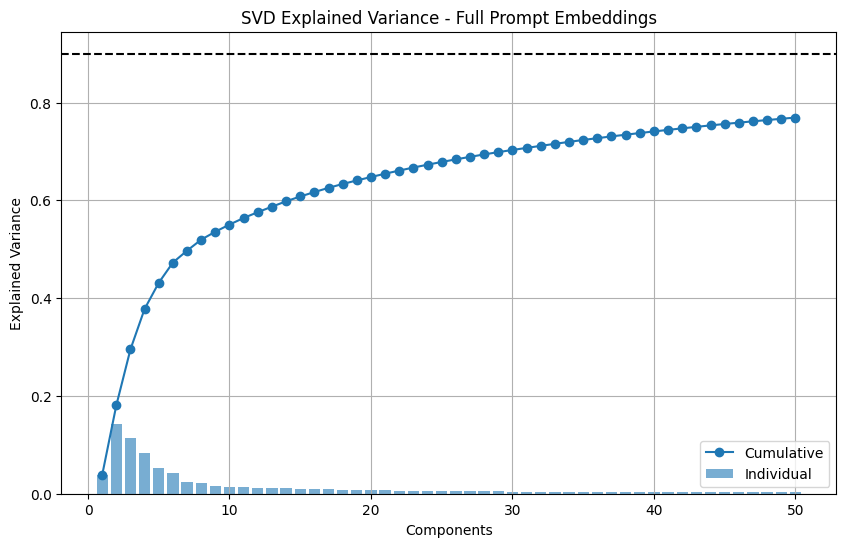

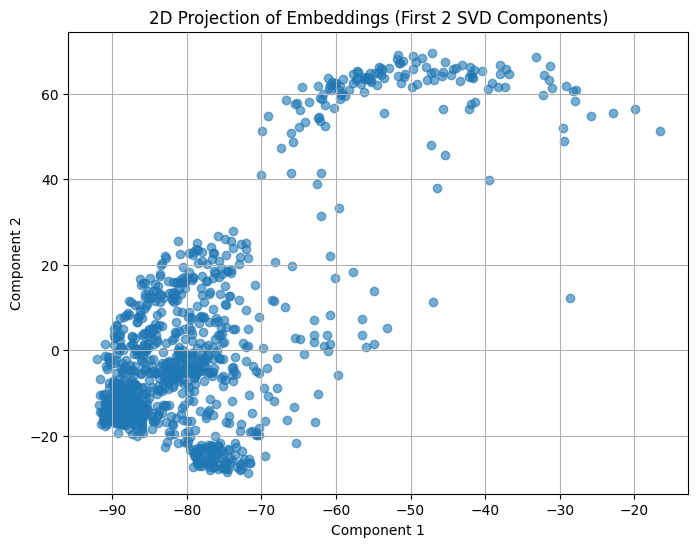

In [ ]:
# === Analyze with SVD ===
svd_model, reduced_matrix = analyze_with_svd(full_matrix, n_components=50, title="Full Prompt Embeddings")

In [ ]:
# === Select Representative Prompts ===
def select_representative_prompts(reduced_matrix, num_select):
    selected_indices = set()
    for i in range(reduced_matrix.shape[1]):
        comp = reduced_matrix[:, i]
        max_idx = np.argmax(np.abs(comp))
        selected_indices.add(max_idx)
        if len(selected_indices) >= num_select:
            break
    return sorted(selected_indices)

# === Coverage Score Function ===
def compute_coverage_score(reduced_matrix, selected_indices):
    selected_vectors = reduced_matrix[selected_indices]
    sims = cosine_similarity(reduced_matrix, selected_vectors)
    max_sim = np.max(sims, axis=1)
    return np.mean(max_sim)

In [ ]:
def greedy_prompt_selection(reduced_matrix, num_select):
    n = reduced_matrix.shape[0]
    selected = []
    remaining = set(range(n))
    
    # Step 1: start with the most 'central' point (highest average sim)
    sims = cosine_similarity(reduced_matrix)
    avg_sims = sims.mean(axis=1)
    first = np.argmax(avg_sims)
    selected.append(first)
    remaining.remove(first)

    # Step 2: greedy selection
    while len(selected) < num_select:
        best_candidate = None
        best_score = -np.inf
        
        for i in remaining:
            temp_selection = selected + [i]
            temp_sims = cosine_similarity(reduced_matrix, reduced_matrix[temp_selection])
            coverage = temp_sims.max(axis=1).mean()
            
            if coverage > best_score:
                best_score = coverage
                best_candidate = i
        
        selected.append(best_candidate)
        remaining.remove(best_candidate)
    
    return selected

[1033]
n=1, coverage score=0.7479

[997, 1033]
n=2, coverage score=0.7921

[476, 997, 1033]
n=3, coverage score=0.8094

[108, 476, 997, 1033]
n=4, coverage score=0.8334

[108, 476, 763, 997, 1033]
n=5, coverage score=0.8404

[108, 476, 763, 905, 997, 1033]
n=6, coverage score=0.8500

[108, 476, 641, 763, 905, 997, 1033]
n=7, coverage score=0.8538

[108, 476, 641, 763, 900, 905, 997, 1033]
n=8, coverage score=0.8568

[108, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=9, coverage score=0.8586

[108, 285, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=10, coverage score=0.8656

[108, 274, 285, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=11, coverage score=0.8698

[108, 193, 274, 285, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=12, coverage score=0.8741

[108, 193, 274, 285, 411, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=13, coverage score=0.8745

[48, 108, 193, 274, 285, 411, 476, 641, 763, 900, 905, 997, 1004, 1033]
n=14, coverage score=0.8756

[48, 108, 193, 274, 285, 411, 476, 641, 720, 

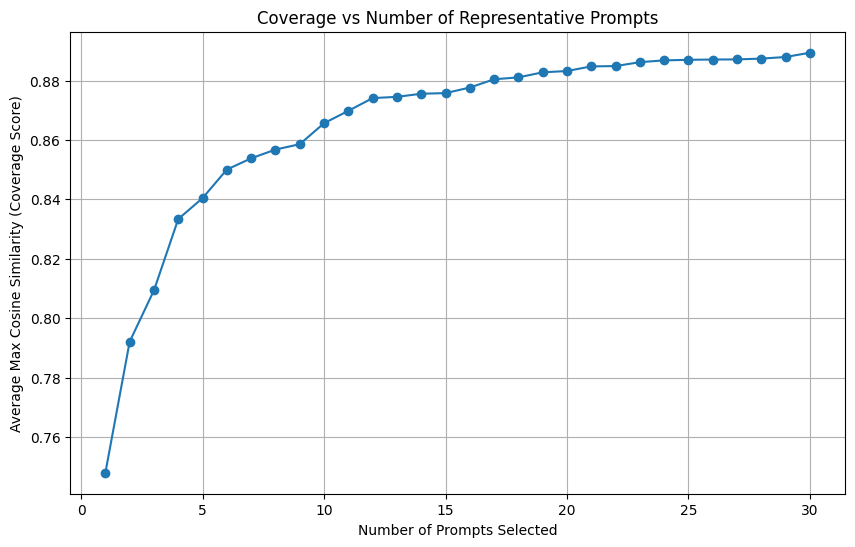

In [ ]:
# === Iterative Test ===
N = 30

coverage_results = []
for n in range(1, N+1):
    selected = select_representative_prompts(reduced_matrix, n)
    print([int(s) for s in selected])
    score = compute_coverage_score(reduced_matrix, selected)
    coverage_results.append(score)
    print(f"n={n}, coverage score={score:.4f}")
    print()

# Plot Coverage Results
plt.figure(figsize=(10, 6))
plt.plot(range(1, N+1), coverage_results, marker='o')
plt.xlabel("Number of Prompts Selected")
plt.ylabel("Average Max Cosine Similarity (Coverage Score)")
plt.title("Coverage vs Number of Representative Prompts")
plt.grid(True)
plt.show()

[Greedy] n=1, coverage score=0.7479
[Greedy] n=2, coverage score=0.7944
[Greedy] n=3, coverage score=0.8208
[Greedy] n=4, coverage score=0.8434
[Greedy] n=5, coverage score=0.8642
[Greedy] n=6, coverage score=0.8762
[Greedy] n=7, coverage score=0.8819
[Greedy] n=8, coverage score=0.8874
[Greedy] n=9, coverage score=0.8916
[Greedy] n=10, coverage score=0.8955
[Greedy] n=11, coverage score=0.8994
[Greedy] n=12, coverage score=0.9030
[Greedy] n=13, coverage score=0.9063
[Greedy] n=14, coverage score=0.9092
[Greedy] n=15, coverage score=0.9120
[Greedy] n=16, coverage score=0.9141
[Greedy] n=17, coverage score=0.9162
[Greedy] n=18, coverage score=0.9182
[Greedy] n=19, coverage score=0.9200
[Greedy] n=20, coverage score=0.9216
[Greedy] n=21, coverage score=0.9230
[Greedy] n=22, coverage score=0.9244
[Greedy] n=23, coverage score=0.9257
[Greedy] n=24, coverage score=0.9268
[Greedy] n=25, coverage score=0.9280
[Greedy] n=26, coverage score=0.9292
[Greedy] n=27, coverage score=0.9303
[Greedy] n

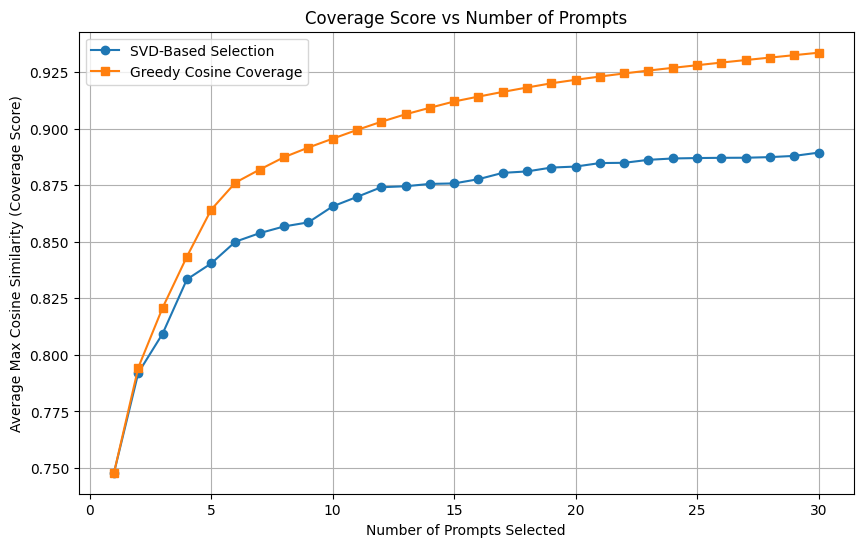

In [ ]:
# === Greedy Iterative Coverage Test ===
def run_greedy_coverage_test(reduced_matrix, max_prompts=N):
    greedy_scores = []
    for n in range(1, max_prompts + 1):
        selected = greedy_prompt_selection(reduced_matrix, n)
        score = compute_coverage_score(reduced_matrix, selected)
        greedy_scores.append(score)
        print(f"[Greedy] n={n}, coverage score={score:.4f}")
    return greedy_scores

# === Run and Plot Greedy Coverage ===
greedy_scores = run_greedy_coverage_test(reduced_matrix, max_prompts=N)

# Plot both SVD and Greedy scores if SVD scores already exist
plt.figure(figsize=(10, 6))
plt.plot(range(1, N+1), coverage_results, label='SVD-Based Selection', marker='o')
plt.plot(range(1, N+1), greedy_scores, label='Greedy Cosine Coverage', marker='s')
plt.xlabel("Number of Prompts Selected")
plt.ylabel("Average Max Cosine Similarity (Coverage Score)")
plt.title("Coverage Score vs Number of Prompts")
plt.legend()
plt.grid(True)
plt.show()